In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.qc import *
from src.energy_calculation import *
from src.utils import write_to_csv 
sns.set_theme(font_scale=1.5)
from tqdm import tqdm
import tikzplotlib
from scipy.optimize import minimize
import pandas as pd

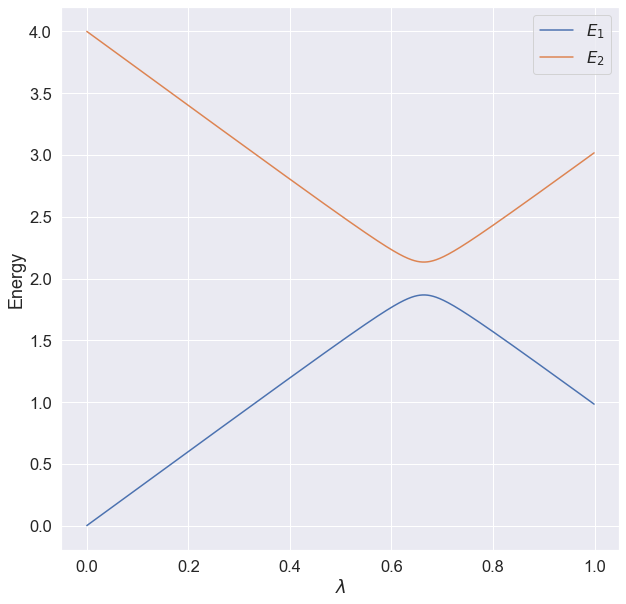

In [2]:
quibit = Qubit(1)
X, Y, Z, I = quibit.X, quibit.Y, quibit.Z, quibit.I
def Hamiltonian(lmb):
    E1 = 0
    E2 = 4
    V11 = 3
    V22 = -3
    V12 = 0.2
    V21 = 0.2

    eps = (E1 + E2) / 2
    omega = (E1 - E2) / 2
    c = (V11 + V22) / 2
    omega_z = (V11 - V22) / 2
    omega_x = V12

    H0 = eps * I + omega * Z
    H1 = c * I + omega_z * Z + omega_x * X
    return H0 + lmb * H1
    
lmbvalues_ana = np.arange(0, 1, 0.001)
eigvals_ana = np.zeros((len(lmbvalues_ana), 2))
for index, lmb in enumerate(lmbvalues_ana):
    H = Hamiltonian(lmb)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for i in range(2):
    axs.plot(lmbvalues_ana, eigvals_ana[:,i], label=f'$E_{i+1}$')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
axs.legend()
plt.show()


In [3]:
qubit = Qubit(1)
unitaries = [qubit.I, qubit.H]

E1 = 0; E2 = 4; V11 = 3; V22 = -3; V12 = 0.2; V21 = 0.2

eps = (E1 + E2) / 2
omega = (E1 - E2) / 2
c = (V11 + V22) / 2
omega_z = (V11 - V22) / 2
omega_x = V12

unitaries = [qubit.I, qubit.H] # for the cirquit measuring Z and X respectively

In [4]:
number_shots = 2**(12)
lmbvalues = np.linspace(0.0, 1.0, 11)
min_energy = np.zeros(len(lmbvalues))
for index, lmb in enumerate(tqdm(lmbvalues)):
    constants = [omega+lmb*omega_z, lmb*omega_x]
    const_term = (eps + lmb*c)
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 2)
    args = (number_shots, unitaries, prepare_state_1D, constants, const_term)
    res = minimize(get_energy, angles_start, args = args, method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy[index] = res.fun

write_to_csv(lmbvalues, min_energy, header='lmb,energy', filename='../data/1D-simple-H')

100%|██████████| 11/11 [00:00<00:00, 15.49it/s]


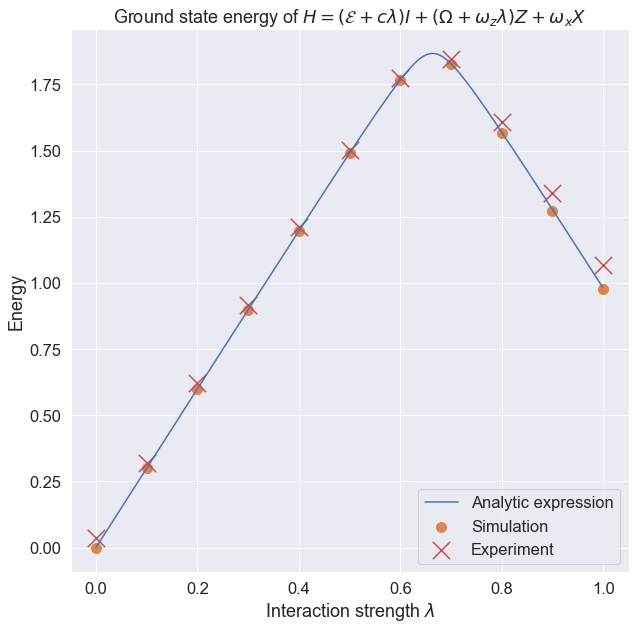

In [5]:
df = pd.read_csv('../data/1D-simple-H.csv')
df_qiskit = pd.read_csv('../data/1D-simple-H_qiskit.csv')
qiskit_lmb = df_qiskit['lmb'].values
qiskit_energies = df_qiskit['energy'].values
lmbvalues = df['lmb'].values
min_energy = df['energy'].values

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for i in range(1):
    axs.plot(lmbvalues_ana, eigvals_ana[:,i], label=f'Analytic expression', color = '#4c72b0')
axs.scatter(lmbvalues, min_energy, label = 'Simulation', color = '#dd8452', marker = 'o', s = 100)
axs.scatter(qiskit_lmb, qiskit_energies, label = 'Experiment', color = '#c44e52', marker = 'x', s = 300)
axs.set_xlabel(r'Interaction strength $\lambda$')
axs.set_ylabel('Energy')
axs.set_title(r'Ground state energy of $H = (\mathcal{E}+ c\lambda)I + (\Omega + \omega_z\lambda) Z + \omega_x X$')
plt.legend(loc = 'lower right')
tikzplotlib.clean_figure()
tikzplotlib.save(
    f'../plots/1D-simple-H.tex',
    extra_axis_parameters=[
        'title style={align=center}',
        'xmajorticks=true',
        'ymajorticks=true',
        'mark options={mark size=1.4pt, line width=1.5pt}',
        ],
        strict=True,
    )
plt.show()